In [1]:
# Loading of all necessary imports
# Using Seaborn instead of matplotlib for most plots as it has more powerful plots out of the box
import pandas as pd
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns
import numpy as np
from matplotlib import colors
import datetime

In [2]:
# imports from sci-kit learn
# Cluster models, pipeline methods and some model selection utilities
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, normalize, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import rand_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn import metrics

In [3]:
sns.set_theme()

In [4]:
# Local source of data
data_path = "../data/"

daily_path = join(data_path, "processed", "daily_data.csv.gz")
dem_path = join(data_path, "processed", "participant_data.csv.gz")
df_participants = pd.read_csv(dem_path, compression='gzip')
df_daily = pd.read_csv(daily_path, compression='gzip')
df_participants.set_index("participant_id", inplace=True)
df_daily.set_index('participant_id', inplace=True)

# Joining all the different dataframes together using participant ID as the key 
df = df_daily.merge(df_participants, how="left", on='participant_id', suffixes=(None, '_dem'))
df.reset_index(inplace=True)

In [5]:
df['WearTime'] = (df['Cardio_minutes'] + df['Fat Burn_minutes'] + df['Peak_minutes'] + df['Out of Range_minutes'])
df = df[df['WearTime'] > 720]
df_g = df.groupby('participant_id').mean()
df_g['Count'] = df.groupby('participant_id')['NumberSteps'].count()
df = df_g
df = df[df['Count'] > 5]



C:\Users\bgrem\AppData\Local\Temp\ipykernel_11800\2791130181.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_g = df.groupby('participant_id').mean()


In [6]:
cluster_features = ['randPhysical', "swls", "psqi", "RestingHeartRate", 'audit', 'pan_PosAffect', 'stai', 'chss_ChallengeStressors', 'chss_HindranceStressors']
df_cluster = df[cluster_features]
df_cluster.describe()

,randPhysical,swls,psqi,RestingHeartRate,audit,pan_PosAffect,stai,chss_ChallengeStressors,chss_HindranceStressors
count,197.000000,197.000000,201.000000,203.000000,199.000000,203.000000,203.000000,195.000000,195.000000
mean,90.504794,5.136294,7.358209,67.287195,2.296482,36.827586,34.911330,3.828938,2.467711
std,20.010247,1.297295,2.396048,7.804208,2.284674,6.789248,8.925546,0.612270,0.692020
min,0.000000,1.000000,3.000000,42.871429,0.000000,16.000000,20.000000,2.125000,1.000000
25%,95.000000,4.400000,5.000000,61.647360,1.000000,32.000000,28.000000,3.500000,2.000000
50%,100.000000,5.400000,7.000000,67.323529,2.000000,38.000000,33.000000,3.875000,2.500000
75%,100.000000,6.000000,9.000000,72.690981,3.000000,41.000000,41.000000,4.250000,3.000000
max,100.000000,7.000000,17.000000,94.033333,13.000000,50.000000,71.000000,5.000000,4.625000


In [7]:
scaler = StandardScaler()
df_cluster[cluster_features] = scaler.fit_transform(df_cluster[cluster_features])
df_cluster.dropna(inplace=True)

C:\Users\bgrem\AppData\Local\Temp\ipykernel_11800\1218996511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster[cluster_features] = scaler.fit_transform(df_cluster[cluster_features])
C:\Users\bgrem\AppData\Local\Temp\ipykernel_11800\1218996511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.dropna(inplace=True)


In [8]:
df_cluster.describe()

,randPhysical,swls,psqi,RestingHeartRate,audit,pan_PosAffect,stai,chss_ChallengeStressors,chss_HindranceStressors
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,0.071319,0.006912,-0.036973,-0.021940,-0.025620,-0.025323,-0.017971,0.007352,-0.009287
std,0.859693,0.985895,0.952937,1.006901,0.978207,1.004148,0.972169,0.999293,0.983950
min,-4.033429,-3.196522,-1.823457,-3.136273,-1.007704,-3.075315,-1.674765,-2.790149,-2.126367
25%,0.225218,-0.569007,-0.986665,-0.734488,-0.568901,-0.712821,-0.776246,-0.538626,-0.677603
50%,0.475726,0.203791,-0.149873,-0.036891,-0.130097,0.173114,-0.214671,0.075426,0.046780
75%,0.475726,0.667470,0.686919,0.653900,0.308706,0.616081,0.683849,0.689477,0.771162
max,0.475726,1.440269,2.778899,3.435616,4.696737,1.944984,4.053297,1.917580,3.125405


<Axes: >

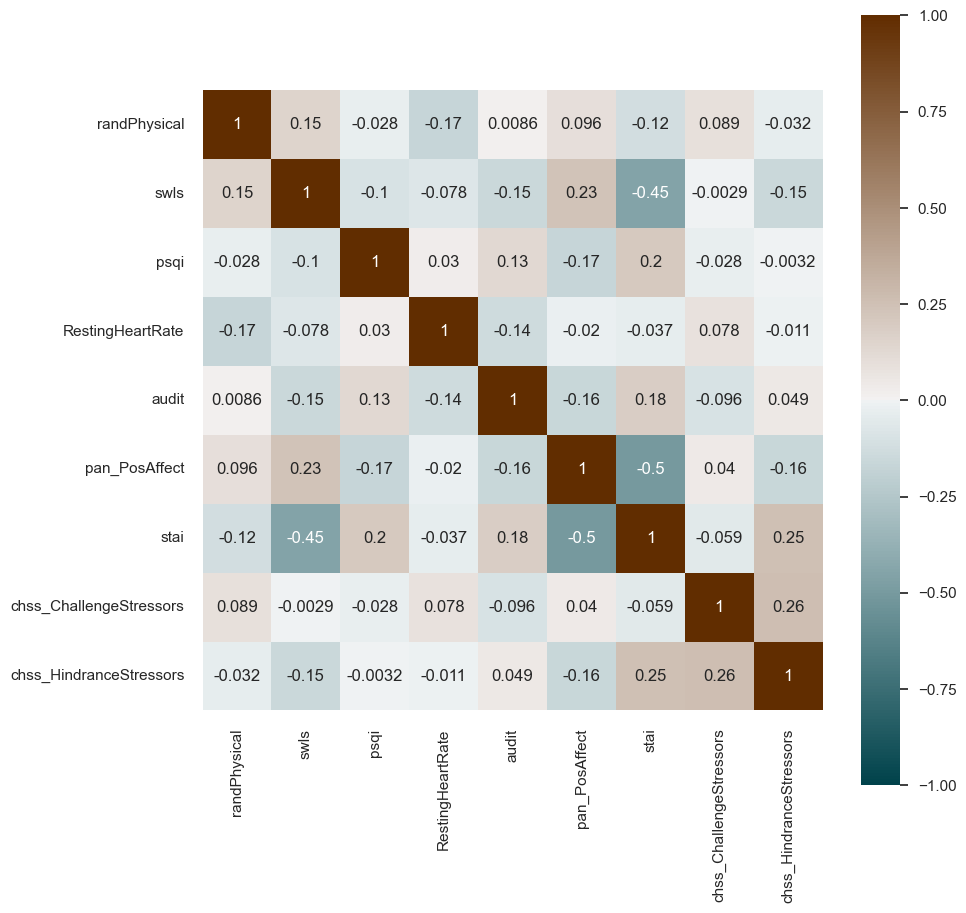

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
corr = df_cluster.corr(numeric_only=True)
sns.heatmap(corr,
    cmap=sns.diverging_palette(210, 30, as_cmap=True, s=100, l=25),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax, annot=True)

In [10]:
#Initiating PCA to reduce dimentions aka features to 2
pca = PCA(n_components=2, random_state=42)
PCA_ds = pd.DataFrame(pca.fit_transform(df_cluster), columns=(["col1","col2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,189.0,4.699357e-17,1.426452,-3.119424,-0.952338,-0.167077,0.905429,6.055255
col2,189.0,-5.639228e-17,1.131353,-3.309632,-0.674375,-0.028604,0.783474,3.348787


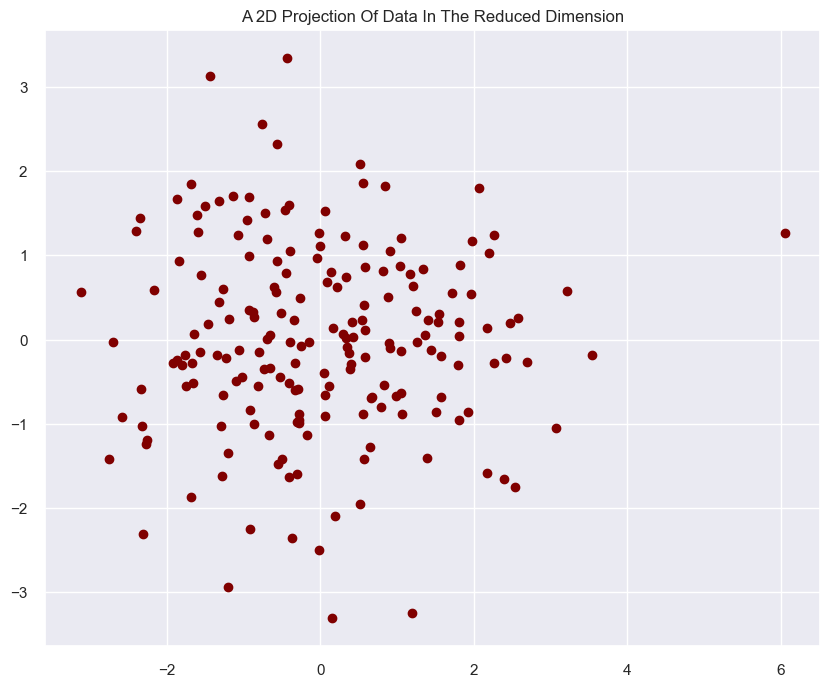

In [11]:
#A 2D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(x,y, c="maroon", marker="o" )
ax.set_title("A 2D Projection Of Data In The Reduced Dimension")
plt.show()

In [12]:
def cluster_analysis(data, n_clusters):
    #Initiating the KMeans clustering model
    KM = KMeans(n_clusters=n_clusters, random_state=42)
    # fit model and predict clusters
    yhat_KM = KM.fit_predict(PCA_ds)
    labels = KM.labels_
    scores = {'davies_bouldin': metrics.davies_bouldin_score(data, labels),
        'silhouette': metrics.silhouette_score(data, labels, metric='euclidean'),
         'calinski_harabasz': metrics.calinski_harabasz_score(data, labels),
             'n_clusters': n_clusters}
    return scores

In [13]:
import warnings
warnings.filterwarnings('ignore')
test = [cluster_analysis(PCA_ds, x) for x in range(3,10)]
df_test = pd.DataFrame(test)

In [14]:
df_test

,davies_bouldin,silhouette,calinski_harabasz,n_clusters
0,0.909986,0.365677,130.973590,3
1,0.940925,0.333813,122.307499,4
2,0.895253,0.326724,121.115637,5
3,0.843133,0.326799,118.068813,6
4,0.849237,0.318947,115.211827,7
5,0.789627,0.327541,116.770834,8
6,0.772568,0.333032,120.816718,9


In [15]:
s = df_test.style
s = s.highlight_max(subset='silhouette',  props='bfseries: ;')
s = s.hide(names=True, level=0, axis=0)
s = s.format_index(escape="latex", axis=0)
s = s.format_index(escape="latex", axis=1)
print(s.to_latex(hrules=True, clines="skip-last;data"))

\begin{tabular}{rrrr}
\toprule
davies\_bouldin & silhouette & calinski\_harabasz & n\_clusters \\
\midrule
0.909986 & \bfseries 0.365677 & 130.973590 & 3 \\
0.940925 & 0.333813 & 122.307499 & 4 \\
0.895253 & 0.326724 & 121.115637 & 5 \\
0.843133 & 0.326799 & 118.068813 & 6 \\
0.849237 & 0.318947 & 115.211827 & 7 \\
0.789627 & 0.327541 & 116.770834 & 8 \\
0.772568 & 0.333032 & 120.816718 & 9 \\
\bottomrule
\end{tabular}



In [16]:
KM = KMeans(n_clusters=3, random_state=42)
yhat_KM = KM.fit_predict(PCA_ds)
df_cluster['Cluster'] = yhat_KM

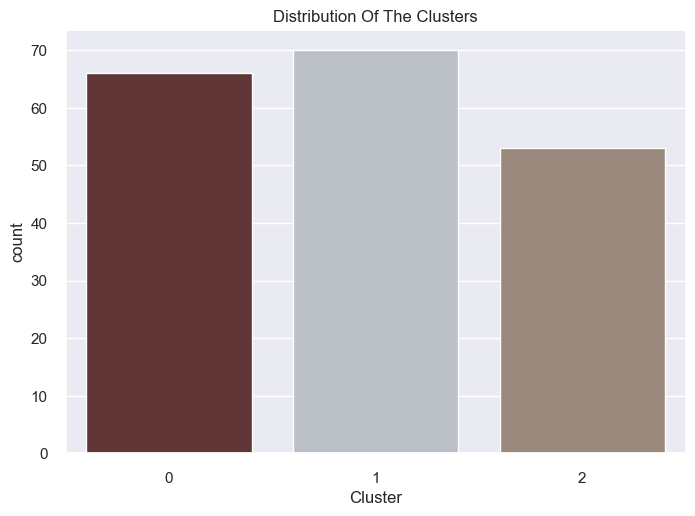

In [17]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60", "#3aF36B", "#AA3DBE", "#3377AA"]
pl = sns.countplot(x=df_cluster['Cluster'], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()
pl.get_figure().savefig('../count_clusters.jpg')

In [18]:
counts = df_cluster.value_counts('Cluster')
counts = [(i, x) for i,x in zip(counts.index, counts)]
counts.sort()
print(', '.join([f'$c{i} = {x}$' for i,x in counts]))
    

$c0 = 66$, $c1 = 70$, $c2 = 53$


<Axes: xlabel='col1', ylabel='col2'>

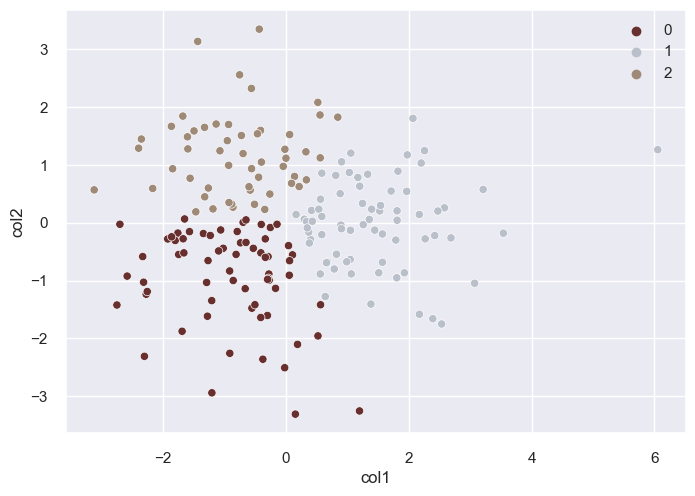

In [19]:
sns.scatterplot(PCA_ds, x="col1", y="col2", hue=yhat_KM, palette=pal)

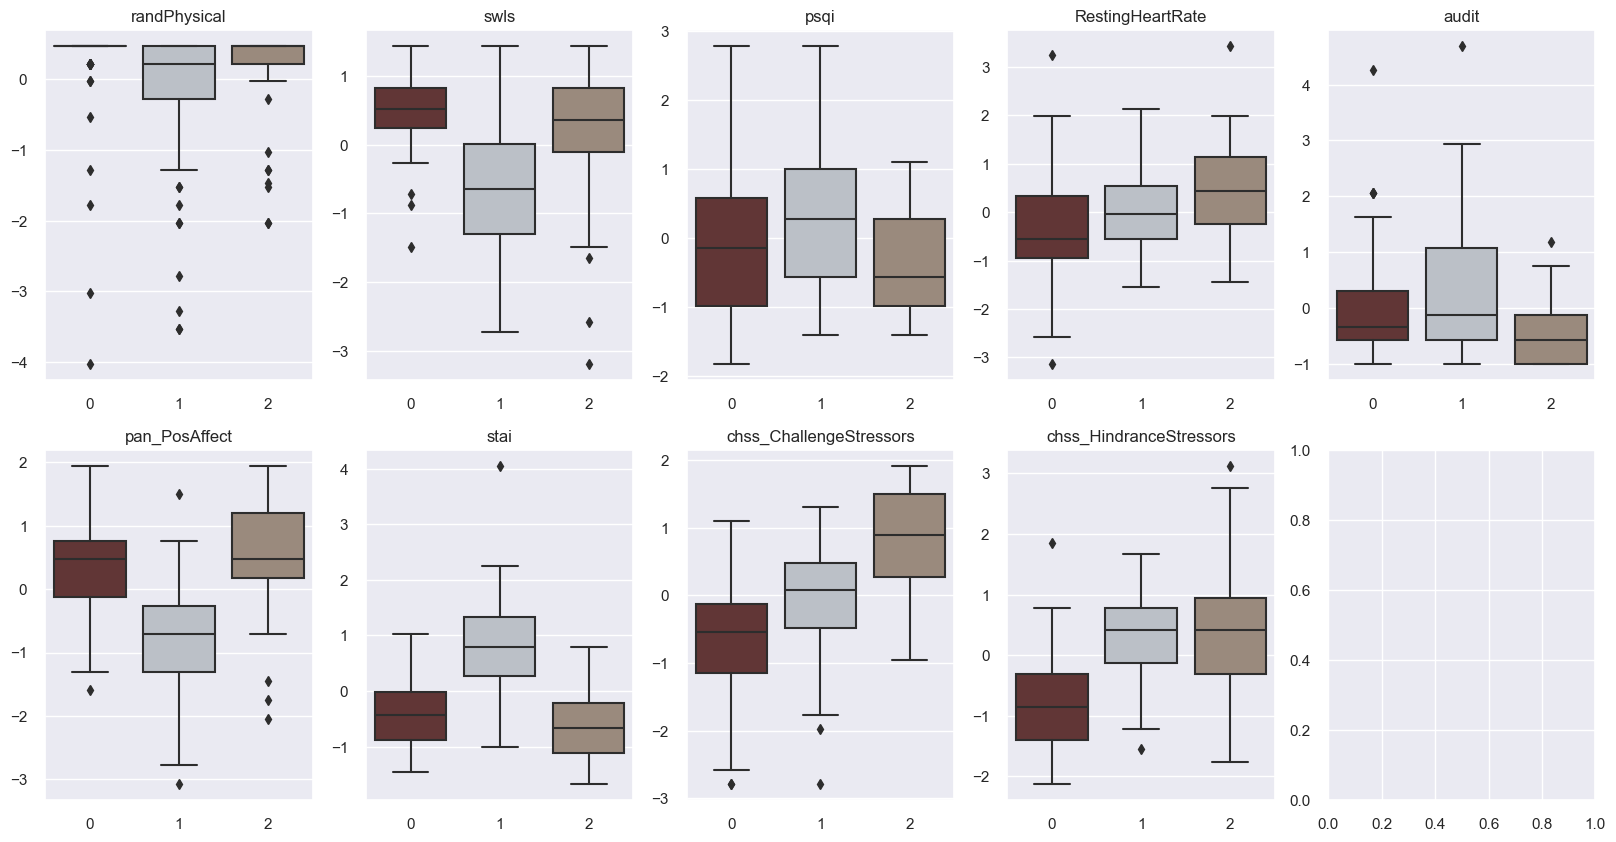

In [20]:
fig, axs = plt.subplots(2,5, figsize=(20,10))
for i, col in enumerate([col for col in df_cluster.columns if col != "Cluster"]):
    ax = sns.boxplot(df_cluster, ax=axs[i//5][i%5], y=col, x="Cluster", palette=pal)
    ax.set_title(col)
    ax.set(ylabel='', xlabel='')
plt.show()
fig.savefig('../cluster_boxes.jpg')